<a href="https://colab.research.google.com/github/Seysande/nle-prediction/blob/main/nle_evaluation_neuralnetwork_SMOTE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load Data and Packages

In [ ]:
!pip install rdkit-pypi
!pip install bayesian-optimization

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.4/29.4 MB 9.5 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from rdkit import Chem
from rdkit.Chem import AllChem, DataStructs
import xgboost as xgb
import seaborn as sns

# Data Preprocessing
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from imblearn.pipeline import Pipeline

# Evaluation
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve, ConfusionMatrixDisplay, confusion_matrix
from sklearn.metrics import precision_recall_curve, auc, precision_score, recall_score, average_precision_score
from bayes_opt import BayesianOptimization
from imblearn.over_sampling import SMOTE

df = pd.read_csv('drugData_jan-2024.csv')
smiles_list = df['smiles'].tolist()

In [ ]:
def smiles_to_mol(smiles):
    try:
        mol = Chem.MolFromSmiles(smiles)
        if mol is None:
            raise ValueError(f"Invalid SMILES string: {smiles}")
        return mol
    except Exception as e:
        print(e)
        return None

molecules = [smiles_to_mol(smiles) for smiles in smiles_list]
molecules = [mol for mol in molecules if mol is not None]
fingerprints = [AllChem.GetMorganFingerprintAsBitVect(mol, radius=2, nBits=2048) for mol in molecules]
df['fingerprint'] = fingerprints
df = df.drop('smiles', axis=1)

X = np.array(list(df['fingerprint']))
y = df['label']
y = np.array(y)

# Training and Optimization

Epoch 1/50, Validation Loss: 1.4773, Validation Accuracy: 0.4974
Epoch 2/50, Validation Loss: 0.4496, Validation Accuracy: 0.8047
Epoch 3/50, Validation Loss: 0.2406, Validation Accuracy: 0.9089
Epoch 4/50, Validation Loss: 0.1966, Validation Accuracy: 0.9401
Epoch 5/50, Validation Loss: 0.2526, Validation Accuracy: 0.9271
Epoch 6/50, Validation Loss: 0.3275, Validation Accuracy: 0.8958
Epoch 7/50, Validation Loss: 0.2468, Validation Accuracy: 0.9349
Epoch 8/50, Validation Loss: 0.3310, Validation Accuracy: 0.9036
Epoch 9/50, Validation Loss: 0.3405, Validation Accuracy: 0.9115
Epoch 10/50, Validation Loss: 0.2995, Validation Accuracy: 0.9245
Epoch 11/50, Validation Loss: 0.4735, Validation Accuracy: 0.8750
Epoch 12/50, Validation Loss: 0.3429, Validation Accuracy: 0.9141
Epoch 13/50, Validation Loss: 0.4038, Validation Accuracy: 0.9089
Epoch 14/50, Validation Loss: 0.4057, Validation Accuracy: 0.8958
Epoch 15/50, Validation Loss: 0.3710, Validation Accuracy: 0.9245
Epoch 16/50, Valida

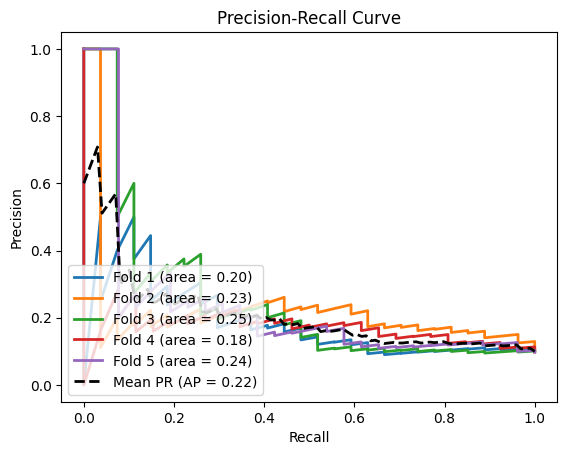

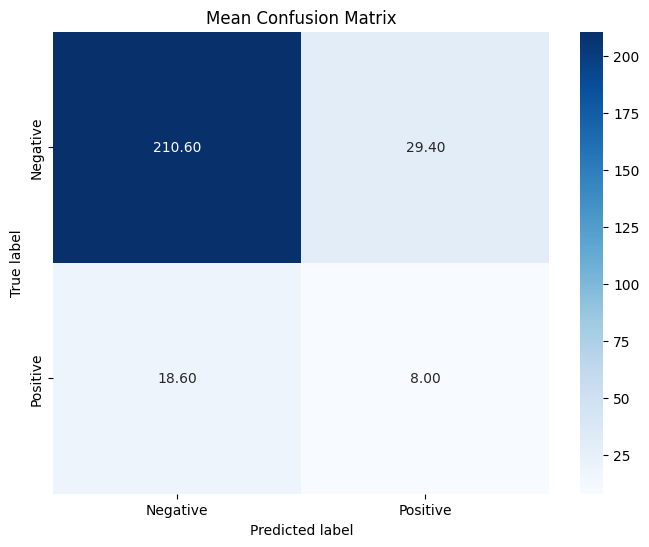

Mean Average Precision: 0.22
Mean Accuracy: 0.82


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from rdkit import Chem
from rdkit.Chem import AllChem
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve, precision_recall_curve, average_precision_score
from imblearn.over_sampling import SMOTE
from torch.optim.lr_scheduler import ReduceLROnPlateau
from imblearn.over_sampling import ADASYN
import seaborn as sns

# Data Preprocessing
def smiles_to_mol(smiles):
    try:
        mol = Chem.MolFromSmiles(smiles)
        if mol is None:
            raise ValueError(f"Invalid SMILES string: {smiles}")
        return mol
    except Exception as e:
        print(e)
        return None

# Neural Network Model
class DrugClassifier(nn.Module):
    def __init__(self, input_size):
        super(DrugClassifier, self).__init__()
        self.fc1 = nn.Linear(input_size, 1024)
        self.bn1 = nn.BatchNorm1d(1024)
        self.fc2 = nn.Linear(1024, 512)
        self.bn2 = nn.BatchNorm1d(512)
        self.fc3 = nn.Linear(512, 256)
        self.bn3 = nn.BatchNorm1d(256)
        self.fc4 = nn.Linear(256, 128)
        self.bn4 = nn.BatchNorm1d(128)
        self.fc5 = nn.Linear(128, 1)
        self.dropout = nn.Dropout(0.4)
        self.leaky_relu = nn.LeakyReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.leaky_relu(self.bn1(self.fc1(x)))
        x = self.dropout(x)
        x = self.leaky_relu(self.bn2(self.fc2(x)))
        x = self.dropout(x)
        x = self.leaky_relu(self.bn3(self.fc3(x)))
        x = self.dropout(x)
        x = self.leaky_relu(self.bn4(self.fc4(x)))
        x = self.dropout(x)
        x = self.sigmoid(self.fc5(x))

        return x

# Training function
def train_model(model, train_loader, val_loader, criterion, optimizer, device, epochs=50):
    for epoch in range(epochs):
        model.train()
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels.unsqueeze(1).float())
            loss.backward()
            optimizer.step()

        # Validation
        model.eval()
        val_loss = 0
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                val_loss += criterion(outputs, labels.unsqueeze(1).float()).item()
                predicted = (outputs > 0.5).int()
                total += labels.size(0)
                correct += (predicted.squeeze() == labels).sum().item()

        val_accuracy = correct / total
        print(f'Epoch {epoch+1}/{epochs}, Validation Loss: {val_loss/len(val_loader):.4f}, Validation Accuracy: {val_accuracy:.4f}')

# Main execution
if __name__ == "__main__":
    # Load and preprocess data
    df = pd.read_csv('drugData_jan-2024.csv')
    smiles_list = df['smiles'].tolist()
    molecules = [smiles_to_mol(smiles) for smiles in smiles_list]
    molecules = [mol for mol in molecules if mol is not None]
    fingerprints = [AllChem.GetMorganFingerprintAsBitVect(mol, radius=2, nBits=2048) for mol in molecules]

    X = np.array([list(fp) for fp in fingerprints])
    y = np.array(df['label'])

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    precision_values = []
    recall_values = []
    average_precisions = []
    fprs, tprs = [], []
    confusion_matrices = []
    accuracies = []

    for fold_idx, (train_index, test_index) in enumerate(kf.split(X, y)):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # Apply SMOTE
        smote = SMOTE(random_state=42)
        X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

        # Split into train and validation
        X_train_res, X_val, y_train_res, y_val = train_test_split(X_train_res, y_train_res, test_size=0.2, random_state=42)

        # Convert to PyTorch tensors
        X_train_tensor = torch.FloatTensor(X_train_res)
        y_train_tensor = torch.LongTensor(y_train_res)
        X_val_tensor = torch.FloatTensor(X_val)
        y_val_tensor = torch.LongTensor(y_val)
        X_test_tensor = torch.FloatTensor(X_test)
        y_test_tensor = torch.LongTensor(y_test)

        # Create data loaders
        train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
        val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
        train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

        # Initialize model, loss, and optimizer
        model = DrugClassifier(input_size=2048).to(device)
        criterion = nn.BCELoss()
        optimizer = optim.Adam(model.parameters(), lr=0.001)

        # Train the model
        train_model(model, train_loader, val_loader, criterion, optimizer, device)

        # Evaluate on test set
        model.eval()
        with torch.no_grad():
            y_pred_prob = model(X_test_tensor.to(device)).cpu().numpy()

        y_pred = (y_pred_prob > 0.5).astype(int)

        precision, recall, _ = precision_recall_curve(y_test, y_pred_prob)
        average_precision = average_precision_score(y_test, y_pred_prob)
        fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
        roc_auc = roc_auc_score(y_test, y_pred_prob)

        fprs.append(fpr)
        tprs.append(tpr)
        precision_values.append(precision)
        recall_values.append(recall)
        average_precisions.append(average_precision)
        cm = confusion_matrix(y_test, y_pred.squeeze())
        confusion_matrices.append(cm)
        accuracy = accuracy_score(y_test, y_pred.squeeze())
        accuracies.append(accuracy)

        plt.plot(recall, precision, lw=2, label=f'Fold {fold_idx+1} (area = {average_precision:.2f})')

    # Plot Precision-Recall Curve
    mean_recall = np.linspace(0, 1, 100)
    precisions = []
    for recall, precision in zip(recall_values, precision_values):
        precisions.append(np.interp(mean_recall, recall[::-1], precision[::-1]))
    mean_precision = np.mean(precisions, axis=0)
    mean_average_precision = np.mean(average_precisions)

    plt.plot(mean_recall, mean_precision, 'k--', lw=2, label=f'Mean PR (AP = {mean_average_precision:.2f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc="lower left")
    plt.show()

    # Plot Confusion Matrix
    mean_confusion_matrix = np.mean(confusion_matrices, axis=0)
    plt.figure(figsize=(8, 6))
    sns.heatmap(mean_confusion_matrix, annot=True, fmt=".2f", cmap="Blues", xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
    plt.title('Mean Confusion Matrix')
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.show()

    # Print results
    mean_accuracy = np.mean(accuracies)
    print(f"Mean Average Precision: {mean_average_precision:.2f}")
    print(f"Mean Accuracy: {mean_accuracy:.2f}")

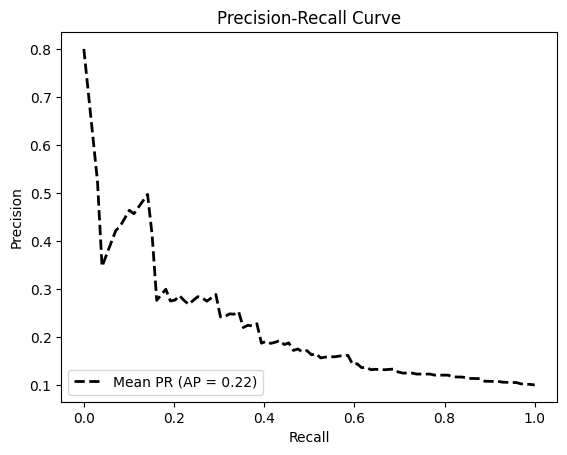

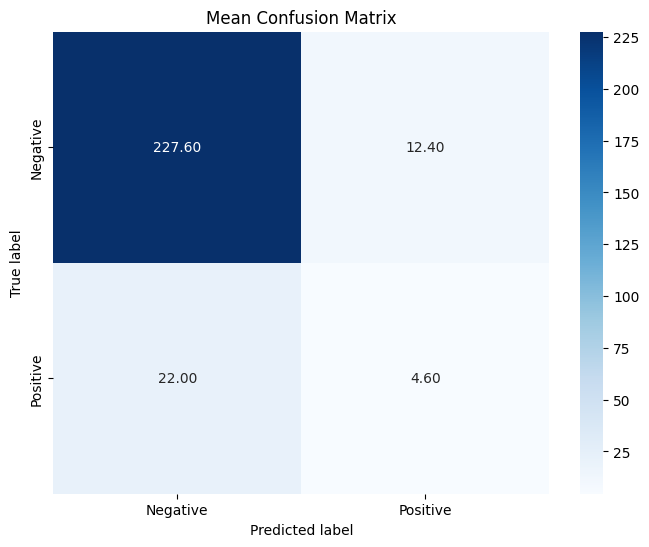

Mean Average Precision: 0.22
Mean Accuracy: 0.87


In [ ]:
mean_recall = np.linspace(0, 1, 100)
precisions = []
for recall, precision in zip(recall_values, precision_values):
  precisions.append(np.interp(mean_recall, recall[::-1], precision[::-1]))
mean_precision = np.mean(precisions, axis=0)

mean_average_precision = np.mean(average_precisions)
plt.plot(mean_recall, mean_precision, 'k--', lw=2, label=f'Mean PR (AP = {mean_average_precision:.2f})')


plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.show()

mean_confusion_matrix = np.mean(confusion_matrices, axis=0)
plt.figure(figsize=(8, 6))
sns.heatmap(mean_confusion_matrix, annot=True, fmt=".2f", cmap="Blues", xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.title('Mean Confusion Matrix')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

mean_accuracy = np.mean(accuracies)
print(f"Mean Average Precision: {mean_average_precision:.2f}")
print(f"Mean Accuracy: {mean_accuracy:.2f}")
